In [ ]:
import os, glob, re, time, math, random
from pathlib import Path

import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

import lightkurve as lk

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_recall_curve,f1_score, classification_report, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Device selection: prefer MPS on Mac M1, otherwise CUDA, otherwise CPU
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print("Using device:", DEVICE)


Using device: mps


In [18]:
# Cell 2 — Configuration (edit paths / params here)
LIGHTCURVE_DIR = "../lightcurves/"   # path to folder containing .fits (can be nested)
KOI_CSV = "../dataset/koi.csv"        # KOI table CSV
CACHE_DIR = "lc_cache_npy/"       # where to save cached normalized flux arrays
SEQ_LEN = 2000                    # sequence length (pad/truncate)
BATCH_SIZE = 16
EPOCHS = 20
RANDOM_SEED = 42
MODEL_OUT = "exoplanet_hybrid.pth"
SCALER_OUT = "koi_scaler.joblib"
FEATURES_OUT = "tab_features_list.joblib"

os.makedirs(CACHE_DIR, exist_ok=True)


In [ ]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(RANDOM_SEED)


In [ ]:
all_fits = glob.glob(os.path.join(LIGHTCURVE_DIR, "**", "*.fits*"), recursive=True)
print("Number of FITS files found (recursive):", len(all_fits))
for f in all_fits[:10]:
    print(" ", os.path.relpath(f, LIGHTCURVE_DIR))
if len(all_fits) == 0:
    raise RuntimeError(f"No FITS files found under {LIGHTCURVE_DIR} — fix path or add files.")


Number of FITS files found (recursive): 8214
  3245969.fits
  8174625.fits
  9467404.fits
  8572936.fits
  7031126.fits
  7609553.fits
  7377343.fits
  11145391.fits
  12785320.fits
  11401869.fits


In [ ]:
koi = pd.read_csv(KOI_CSV)
print("KOI rows:", len(koi))
print("Sample columns:", list(koi.columns)[:40])
koi.head(2)


KOI rows: 9564
Sample columns: ['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_disp_prov', 'koi_comment', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_time0', 'koi_time0_err1', 'koi_time0_err2', 'koi_eccen', 'koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_depth']


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,...,0.2,0.16,0.20,0.17,0.08,0.13,0.31,0.17,0.32,0.16
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,...,0.0,0.48,0.39,0.36,0.49,0.34,0.12,0.73,0.50,0.45


In [ ]:

numeric_candidates = [
    "koi_period", "koi_duration", "koi_depth",
    "koi_prad", "koi_ror", "koi_model_snr",
    "koi_num_transits", "koi_steff", "koi_slogg",
    "koi_srad", "koi_smass", "koi_kepmag",
    "koi_insol", "koi_dor", "koi_count", "koi_score"
]
num_features = [c for c in numeric_candidates if c in koi.columns]
print("Numeric features used:", num_features)

# Categorical (koi_pdisposition -> pdisp_code)
cat_features = []
if "koi_pdisposition" in koi.columns:
    koi["pdisp_code"] = koi["koi_pdisposition"].map({
        "FALSE POSITIVE": 0, "CANDIDATE": 1, "CONFIRMED": 2
    }).fillna(-1).astype(int)
    cat_features.append("pdisp_code")
    print("Using categorical feature: pdisp_code")

# Label mapping (we treat CANDIDATE as positive; change if desired)
disp_map = {"FALSE POSITIVE": 0, "CANDIDATE": 1, "CONFIRMED": 2}
koi["label"] = koi["koi_disposition"].map(disp_map).astype("Int64")

print("Label counts (0=FALSE POSITIVE, 1=CANDIDATE, 2=CONFIRMED):")
print(koi["label"].value_counts().sort_index())


Numeric features used: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_ror', 'koi_model_snr', 'koi_num_transits', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag', 'koi_insol', 'koi_dor', 'koi_count', 'koi_score']
Using categorical feature: pdisp_code
Label counts (0=FALSE POSITIVE, 1=CANDIDATE, 2=CONFIRMED):
label
0    4839
1    1979
2    2746
Name: count, dtype: Int64


In [ ]:
feature_cols = num_features + cat_features
print("Preparing feature columns:", feature_cols)

for c in feature_cols:
    # Coerce strings to numeric
    koi[c] = pd.to_numeric(koi[c], errors='coerce')
    med = np.nanmedian(koi[c].values)
    if not np.isfinite(med):
        med = 0.0
    koi[c] = koi[c].fillna(med).astype(np.float32)

print("Dtypes after coercion:")
print(koi[feature_cols].dtypes)


Preparing feature columns: ['koi_period', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_ror', 'koi_model_snr', 'koi_num_transits', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_kepmag', 'koi_insol', 'koi_dor', 'koi_count', 'koi_score', 'pdisp_code']
Dtypes after coercion:
koi_period          float32
koi_duration        float32
koi_depth           float32
koi_prad            float32
koi_ror             float32
koi_model_snr       float32
koi_num_transits    float32
koi_steff           float32
koi_slogg           float32
koi_srad            float32
koi_smass           float32
koi_kepmag          float32
koi_insol           float32
koi_dor             float32
koi_count           float32
koi_score           float32
pdisp_code          float32
dtype: object


In [ ]:

all_fits = glob.glob(os.path.join(LIGHTCURVE_DIR, "**", "*.fits*"), recursive=True)
print("Total FITS found (recursive):", len(all_fits))

fits_map = {}
for f in all_fits:
    name = os.path.basename(f)
    m = re.search(r'(\d{6,9})', name)  # match 6-9 digits likely containing kepid
    if m:
        token = m.group(1)
        try:
            fits_map[int(token)] = f
        except:
            pass

# Matching function using the map and tolerant padding
def match_fits_for_kepid(kepid):
    try:
        k = int(float(kepid))
    except:
        return None
    if k in fits_map:
        return fits_map[k]
    # try padded versions (7..9)
    for pad in (7,8,9):
        kp = int(str(k).zfill(pad))
        if kp in fits_map:
            return fits_map[kp]
    # fallback: substring search of filenames (slower)
    kstr = str(k)
    for f in all_fits:
        if kstr in os.path.basename(f):
            return f
    return None

# Apply mapping and report
koi['fits_path'] = koi['kepid'].apply(lambda x: match_fits_for_kepid(x) if not pd.isna(x) else None)
found = koi['fits_path'].notna().sum()
print(f"Mapped FITS files for {found} / {len(koi)} KOI rows")
if found == 0:
    raise RuntimeError("No fits mapped — check filenames and kepid formats.")


Total FITS found (recursive): 8214
Mapped FITS files for 9564 / 9564 KOI rows


In [ ]:
koi = koi[~koi['fits_path'].isna()].reset_index(drop=True)
print("KOI rows after keeping mapped FITS:", len(koi))


KOI rows after keeping mapped FITS: 9564


In [ ]:
X_tab = koi[feature_cols].values.astype(np.float32)
y_arr = koi['label'].values.astype(np.float32)
fits_paths = koi['fits_path'].values
print("X_tab shape:", X_tab.shape, "y shape:", y_arr.shape)

# Any NaNs left?
print("NaNs per column:", dict(zip(feature_cols, np.isnan(X_tab).sum(axis=0).tolist())))

# Scale numeric features (we scale the entire tabular vector including categorical small ints here)
scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)
joblib.dump(scaler, SCALER_OUT)
joblib.dump(feature_cols, FEATURES_OUT)
print("Saved scaler and feature list.")


X_tab shape: (9564, 17) y shape: (9564,)
NaNs per column: {'koi_period': 0, 'koi_duration': 0, 'koi_depth': 0, 'koi_prad': 0, 'koi_ror': 0, 'koi_model_snr': 0, 'koi_num_transits': 0, 'koi_steff': 0, 'koi_slogg': 0, 'koi_srad': 0, 'koi_smass': 0, 'koi_kepmag': 0, 'koi_insol': 0, 'koi_dor': 0, 'koi_count': 0, 'koi_score': 0, 'pdisp_code': 0}
Saved scaler and feature list.


In [ ]:
def process_and_cache_flux(fits_path, seq_len=SEQ_LEN, cache_dir=CACHE_DIR):
    # derive cache name from kepid or filename
    base_match = re.search(r'(\d{6,9})', os.path.basename(fits_path))
    if base_match:
        base = base_match.group(1)
    else:
        base = Path(fits_path).stem
    cache_path = os.path.join(cache_dir, f"{base}.npy")
    if os.path.exists(cache_path):
        arr = np.load(cache_path)
        return cache_path, arr

    # Read with lightkurve robustly
    try:
        lc = lk.read(fits_path)
    except Exception as e:
        print("Read error:", fits_path, e)
        arr = np.ones(seq_len, dtype=np.float32)
        np.save(cache_path, arr)
        return cache_path, arr

    # prefer PDCSAP_FLUX then SAP_FLUX then attempt lc.flux
    arr = None
    try:
        if hasattr(lc, "PDCSAP_FLUX") and lc.PDCSAP_FLUX is not None:
            arr = lc.PDCSAP_FLUX.value
        elif hasattr(lc, "SAP_FLUX") and lc.SAP_FLUX is not None:
            arr = lc.SAP_FLUX.value
        else:
            # try generic attribute names
            arr = getattr(lc, "flux", None)
            if arr is None:
                arr = np.zeros(seq_len)
    except Exception:
        arr = np.zeros(seq_len)

    arr = np.asarray(arr, dtype=np.float32)
    # Normalize by median safely
    if np.all(np.isnan(arr)) or np.nanmax(np.abs(arr)) == 0:
        arr = np.ones(seq_len, dtype=np.float32)
    else:
        med = np.nanmedian(arr)
        if not np.isfinite(med) or med == 0:
            med = 1.0
        arr = np.nan_to_num(arr / med, nan=0.0, posinf=0.0, neginf=0.0)

    # pad/truncate
    if len(arr) < seq_len:
        padded = np.ones(seq_len, dtype=np.float32)
        padded[:len(arr)] = arr
        arr = padded
    else:
        arr = arr[:seq_len]

    np.save(cache_path, arr)
    return cache_path, arr


In [ ]:
DO_PRECACHE = False   # set True if you want to create .npy for all fits now
if DO_PRECACHE:
    print("Caching all light curves to", CACHE_DIR)
    unique_paths = np.unique(fits_paths)
    for p in unique_paths:
        process_and_cache_flux(p, seq_len=SEQ_LEN, cache_dir=CACHE_DIR)
    print("Caching done.")


In [ ]:
class ExoplanetDataset(Dataset):
    def __init__(self, fits_paths, X_tab_scaled, y_arr, indices, seq_len=SEQ_LEN, cache_dir=CACHE_DIR):
        self.fits = np.array(fits_paths)[indices]
        self.tab = X_tab_scaled[indices]
        self.y = y_arr[indices]
        self.seq_len = seq_len
        self.cache_dir = cache_dir

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        fits_path = self.fits[idx]
        # Use cached npy if exists, else process and cache
        base_match = re.search(r'(\d{6,9})', os.path.basename(fits_path)) if fits_path else None
        cache_path = None
        if base_match:
            cache_path = os.path.join(self.cache_dir, f"{base_match.group(1)}.npy")
        if cache_path and os.path.exists(cache_path):
            flux = np.load(cache_path)
        else:
            _, flux = process_and_cache_flux(fits_path, seq_len=self.seq_len, cache_dir=self.cache_dir)
        # tensors
        lc_tensor = torch.from_numpy(flux).float().unsqueeze(0)  # (1, SEQ_LEN)
        tab_tensor = torch.from_numpy(self.tab[idx]).float()
        label = torch.tensor(self.y[idx], dtype=torch.float32)
        return lc_tensor, tab_tensor, label

# Train/val split grouped by kepid to avoid leakage
unique_kepids = np.unique(koi['kepid'])
train_kepids, val_kepids = train_test_split(unique_kepids, test_size=0.2, random_state=RANDOM_SEED)
train_mask = np.isin(koi['kepid'], train_kepids)
val_mask = np.isin(koi['kepid'], val_kepids)
train_idx = np.where(train_mask)[0]
val_idx = np.where(val_mask)[0]
print("Train rows:", len(train_idx), "Val rows:", len(val_idx))

train_ds = ExoplanetDataset(fits_paths, X_tab_scaled, y_arr, train_idx, seq_len=SEQ_LEN, cache_dir=CACHE_DIR)
val_ds = ExoplanetDataset(fits_paths, X_tab_scaled, y_arr, val_idx, seq_len=SEQ_LEN, cache_dir=CACHE_DIR)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# Sanity check shapes
lc_b, tab_b, y_b = next(iter(train_loader))
print("Batch shapes:", lc_b.shape, tab_b.shape, y_b.shape)


Train rows: 7662 Val rows: 1902
Batch shapes: torch.Size([16, 1, 2000]) torch.Size([16, 17]) torch.Size([16])


In [14]:
class HybridExoNet(nn.Module):
    def __init__(self, seq_len, tab_dim, num_classes=3):
        super().__init__()
        # --- Light curve CNN encoder ---
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(32, 64, kernel_size=9, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        # --- Fully connected (light curve) ---
        self.lc_fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Tabular MLP ---
        self.tab_fc = nn.Sequential(
            nn.Linear(tab_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # --- Fusion Head (outputs logits for 3 classes) ---
        self.head = nn.Sequential(
            nn.Linear(128 + 32, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)  # 3 outputs (no sigmoid here)
        )

    def forward(self, x_lc, x_tab):
        a = self.cnn(x_lc)
        a = self.lc_fc(a)
        b = self.tab_fc(x_tab)
        c = torch.cat([a, b], dim=1)
        out = self.head(c)  # raw logits
        return out


# ---- Instantiate model ----
tab_dim = X_tab_scaled.shape[1]
model = HybridExoNet(SEQ_LEN, tab_dim, num_classes=3).to(DEVICE)

print(model)


HybridExoNet(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    (7): ReLU()
    (8): AdaptiveAvgPool1d(output_size=1)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (lc_fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
  )
  (tab_fc): Sequential(
    (0): Linear(in_features=17, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=3, factor=0.5
)

# ---- Evaluation helper ----
def evaluate_model(model, loader, device=DEVICE):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for lc, tab, y in loader:
            lc, tab = lc.to(device), tab.to(device)
            outputs = model(lc, tab)
            prob = torch.softmax(outputs, dim=1).cpu().numpy()  # shape [batch, 3]
            ys.append(y.numpy())
            ps.append(prob)
    ys = np.concatenate(ys)
    ps = np.vstack(ps)
    
    # Compute metrics
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    acc = accuracy_score(ys, np.argmax(ps, axis=1))
    f1 = f1_score(ys, np.argmax(ps, axis=1), average='weighted')
    report = classification_report(ys, np.argmax(ps, axis=1), target_names=["FALSE POSITIVE","CANDIDATE","CONFIRMED"])
    confmat = confusion_matrix(ys, np.argmax(ps, axis=1))
    
    return {"acc": acc, "f1": f1, "report": report, "confmat": confmat, "y": ys, "probs": ps}


# ---- Training loop ----
best_val_acc = -1.0
for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    t0 = time.time()

    for lc, tab, y in train_loader:
        lc, tab, y = lc.to(DEVICE), tab.to(DEVICE), y.to(DEVICE).long()

        optimizer.zero_grad()
        outputs = model(lc, tab)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * lc.size(0)

    epoch_loss /= len(train_loader.dataset)

    # ---- Validation ----
    val_stats = evaluate_model(model, val_loader, device=DEVICE)
    val_acc = val_stats["acc"]
    print(f"Epoch {epoch}/{EPOCHS} | Loss: {epoch_loss:.4f} | "
          f"Val_Acc: {val_acc:.4f} | F1: {val_stats['f1']:.4f} | "
          f"Time: {time.time()-t0:.1f}s")

    scheduler.step(val_acc if not math.isnan(val_acc) else 0.0)

    if not math.isnan(val_acc) and val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_OUT)
        joblib.dump(scaler, SCALER_OUT)
        print("✅ Saved best model (val_acc:", best_val_acc, ")")

# ---- After training ----
print("\nBest Validation Accuracy:", best_val_acc)
final_eval = evaluate_model(model, val_loader, device=DEVICE)
print("\nFinal Classification Report:\n", final_eval["report"])
print("\nConfusion Matrix:\n", final_eval["confmat"])


Epoch 1/20 | Loss: 0.2641 | Val_Acc: 0.8891 | F1: 0.8852 | Time: 7.2s
✅ Saved best model (val_acc: 0.8890641430073607 )
Epoch 2/20 | Loss: 0.2678 | Val_Acc: 0.8912 | F1: 0.8881 | Time: 5.4s
✅ Saved best model (val_acc: 0.8911671924290221 )
Epoch 3/20 | Loss: 0.2584 | Val_Acc: 0.8870 | F1: 0.8816 | Time: 5.5s
Epoch 4/20 | Loss: 0.2498 | Val_Acc: 0.8896 | F1: 0.8843 | Time: 5.5s
Epoch 5/20 | Loss: 0.2534 | Val_Acc: 0.8885 | F1: 0.8842 | Time: 5.4s
Epoch 6/20 | Loss: 0.2521 | Val_Acc: 0.8917 | F1: 0.8884 | Time: 5.4s
✅ Saved best model (val_acc: 0.8916929547844374 )
Epoch 7/20 | Loss: 0.2535 | Val_Acc: 0.8927 | F1: 0.8894 | Time: 5.5s
✅ Saved best model (val_acc: 0.8927444794952681 )
Epoch 8/20 | Loss: 0.2515 | Val_Acc: 0.8901 | F1: 0.8862 | Time: 5.4s
Epoch 9/20 | Loss: 0.2501 | Val_Acc: 0.8917 | F1: 0.8867 | Time: 5.4s
Epoch 10/20 | Loss: 0.2505 | Val_Acc: 0.8854 | F1: 0.8788 | Time: 5.4s
Epoch 11/20 | Loss: 0.2490 | Val_Acc: 0.8896 | F1: 0.8841 | Time: 5.4s
Epoch 12/20 | Loss: 0.2468 |

Final Validation Accuracy: 0.8937960042060988
Final Weighted F1 Score: 0.8901967101073478

Classification Report:
                 precision    recall  f1-score   support

FALSE POSITIVE       1.00      1.00      1.00       981
     CANDIDATE       0.85      0.61      0.71       395
     CONFIRMED       0.76      0.91      0.83       526

      accuracy                           0.89      1902
     macro avg       0.87      0.84      0.84      1902
  weighted avg       0.90      0.89      0.89      1902


Confusion Matrix:
 [[979   0   2]
 [  1 240 154]
 [  3  42 481]]


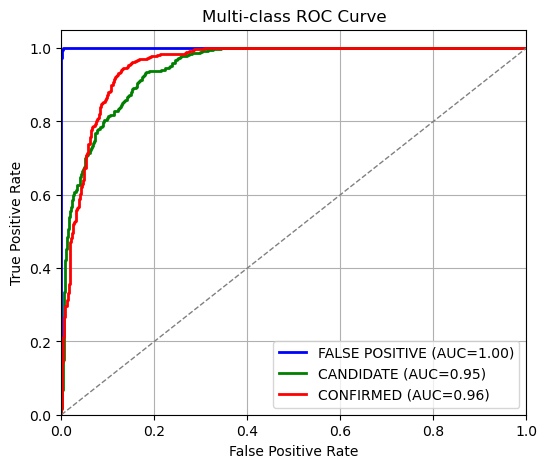

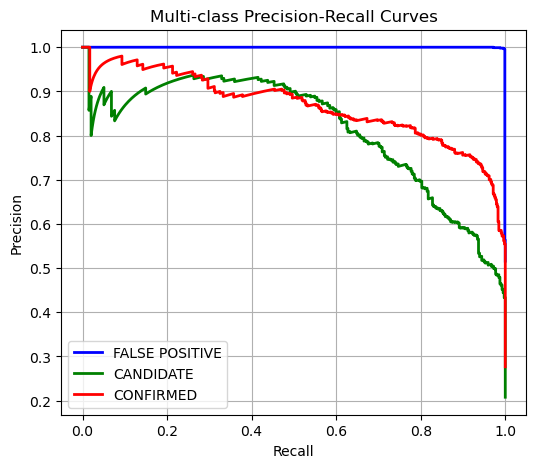

In [ ]:
from sklearn.preprocessing import label_binarize

model.load_state_dict(torch.load(MODEL_OUT, map_location=DEVICE))

res = evaluate_model(model, val_loader, device=DEVICE)
print("Final Validation Accuracy:", res['acc'])
print("Final Weighted F1 Score:", res['f1'])
print("\nClassification Report:\n", res['report'])
print("\nConfusion Matrix:\n", res['confmat'])

# y_true and predicted probabilities
y_true = res['y']
probs = []

# Recompute probabilities
model.eval()
with torch.no_grad():
    for lc, tab, y in val_loader:
        lc, tab = lc.to(DEVICE), tab.to(DEVICE)
        outputs = model(lc, tab)
        p = torch.softmax(outputs, dim=1).cpu().numpy()
        probs.append(p)
probs = np.vstack(probs)  # shape [n_samples, 3]

# Binarize labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=[0,1,2])
classes = ["FALSE POSITIVE", "CANDIDATE", "CONFIRMED"]
colors = ['blue','green','red']

plt.figure(figsize=(6,5))
for i, color in enumerate(colors):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{classes[i]} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---- Multi-class Precision-Recall Curves ----
plt.figure(figsize=(6,5))
for i, color in enumerate(colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=classes[i])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curves")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


In [31]:
# Cell 17 — Save artifacts & final notes
print("Model saved to:", MODEL_OUT)
print("Scaler saved to:", SCALER_OUT)
print("Tabular feature list saved to:", FEATURES_OUT)
print("Cache folder:", CACHE_DIR)

Model saved to: exoplanet_hybrid.pth
Scaler saved to: koi_scaler.joblib
Tabular feature list saved to: tab_features_list.joblib
Cache folder: lc_cache_npy/
